In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
#Эта строка устанавливает размер по умолчанию для всех создаваемых фигур (графиков или изображений) в Matplotlib.
#rcParams - это словарь, содержащий настройки по умолчанию для Matplotlib.
#'figure.figsize' - это ключ, отвечающий за размер фигуры.
#[9, 6] устанавливает ширину в 9 дюймов и высоту в 6 дюймов для всех новых фигур.

In [2]:
import math

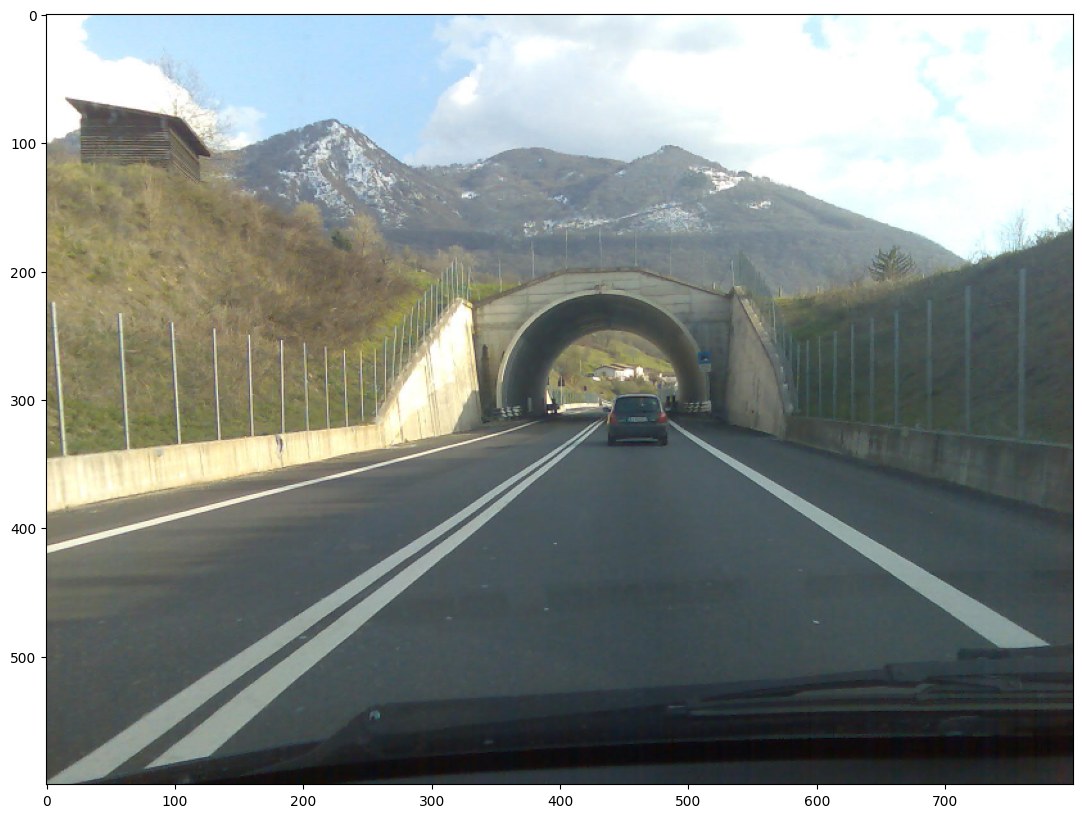

In [3]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
k_resize = 0.5
img_resized = cv2.resize(img, None, fx=k_resize, fy=k_resize)
'''Уменьшение шума: Уменьшение размера может помочь сгладить некоторые мелкие детали, которые могут мешать обнаружению линий.
Стандартизация входных данных: Если алгоритм настроен на работу с изображениями определенного размера, 
это поможет привести входные данные к нужному формату.'''
plt.imshow(img_resized)

In [4]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

In [5]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges =  cv2.Canny(gray, 100, 150)
edges_resized =  cv2.Canny(gray_resized, 100, 150)

In [6]:
# We are only interseted in the road so we will remove everything above the horizon
height = 700
edges[0:height] = 0
zerohead = int(height*k_resize)
edges_resized[0:zerohead] = 0

(<Axes: title={'center': 'Edge_resized map'}>,
 Text(0.5, 1.0, 'Edge_resized map'))

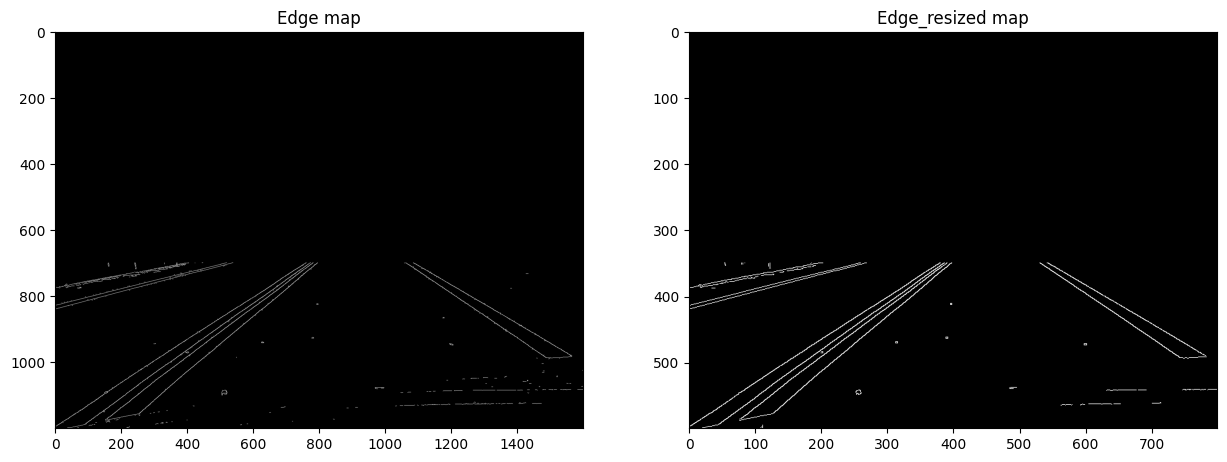

In [7]:
# Let's plot the images
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(edges_resized, cmap='gray'), plt.title('Edge_resized map')

(<Axes: title={'center': 'Hough_resized lines'}>,
 Text(0.5, 1.0, 'Hough_resized lines'))

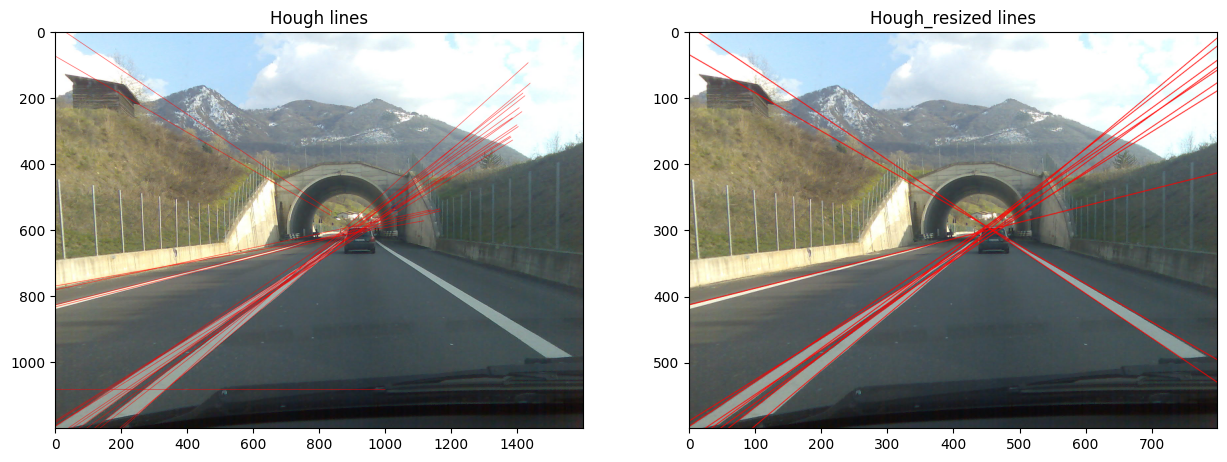

In [8]:
# Apply Hough transform to parametrize the lines
rho = 2  # Offset resolution of 2 pixels
theta = np.pi / 90  # Slope resolution of 2 degrees
threshold = 190  # Accumulator threshold

lines = cv2.HoughLines(edges, rho, theta, threshold)
lines_resized = cv2.HoughLines(edges_resized, rho, theta, threshold)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]
lines_resized = lines_resized[:, 0, :]

# Plot the resulting Hough lines
result = np.copy(img)
result_resized = np.copy(img_resized)

for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
    
for line_resized in lines_resized:
    rho = line_resized[0]
    theta = line_resized[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_resized, pt1, pt2, 255, 1, cv2.LINE_AA)

# Display results
plt.subplot(121), plt.imshow(result, cmap='gray'), plt.title('Hough lines')
plt.subplot(122), plt.imshow(result_resized, cmap='gray'), plt.title('Hough_resized lines')

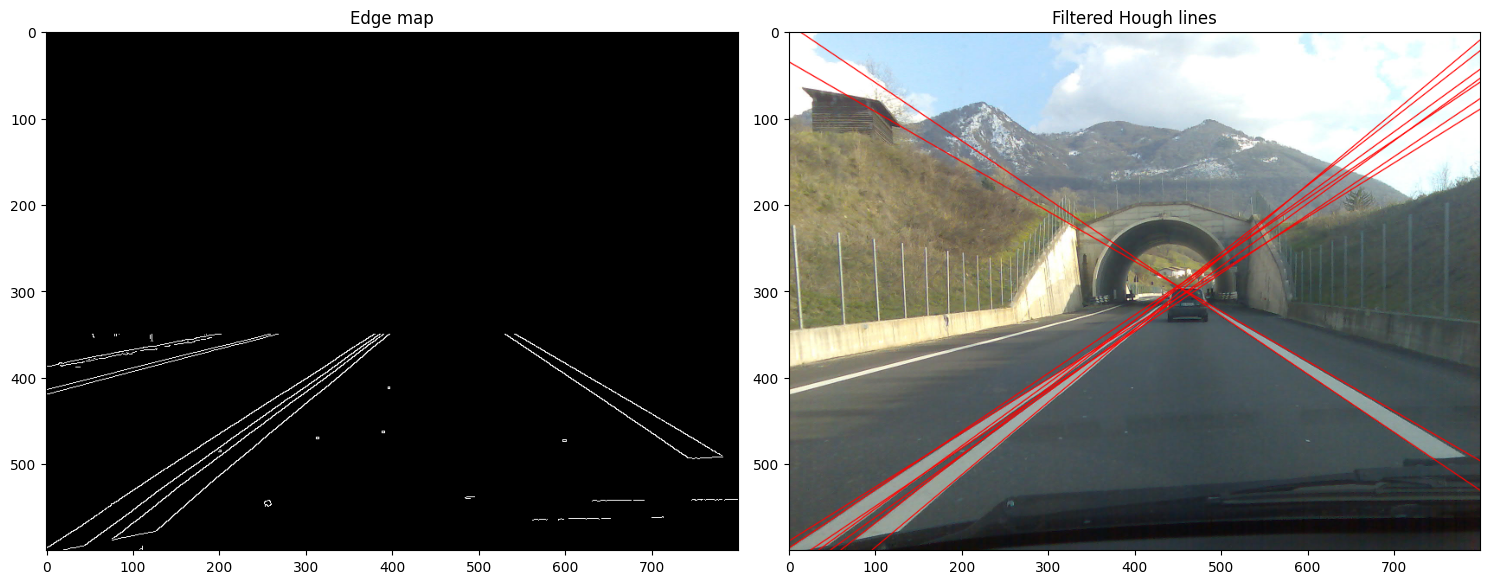

In [9]:
edges = edges_resized
lines = lines_resized
result = result_resized
img = img_resized

filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Convert theta to degrees
    theta_deg = theta * 180 / np.pi
    # Keep line if theta is not horizontal (not within +/- 20 degrees of 90 or 270 degrees)
    if abs(theta_deg - 90) > 20 and abs(theta_deg - 270) > 20:
        filtered_lines.append(line)

# Convert filtered_lines back to numpy array
filtered_lines = np.array(filtered_lines)

# Plot the filtered Hough lines
result_filtered = np.copy(img)

for line in filtered_lines:
    rho, theta = line
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_filtered, pt1, pt2, 255, 1, cv2.LINE_AA)

# Display results including filtered lines
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result_filtered, cmap='gray'), plt.title('Filtered Hough lines')
plt.tight_layout()
plt.show()

In [10]:
#Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.
# We will apply k-means clustering to refine the detected lines.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[511.        ,   0.94247776],
       [ 31.        ,   2.0943952 ],
       [ -7.        ,   2.1642082 ],
       [497.        ,   0.99483764],
       [521.        ,   0.87266463],
       [505.        ,   0.94247776]], dtype=float32)

In [12]:
# Создаем новое изображение для отображения результатов
result = np.copy(img)

# Отображаем линии, соответствующие центрам кластеров
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 2, cv2.LINE_AA)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

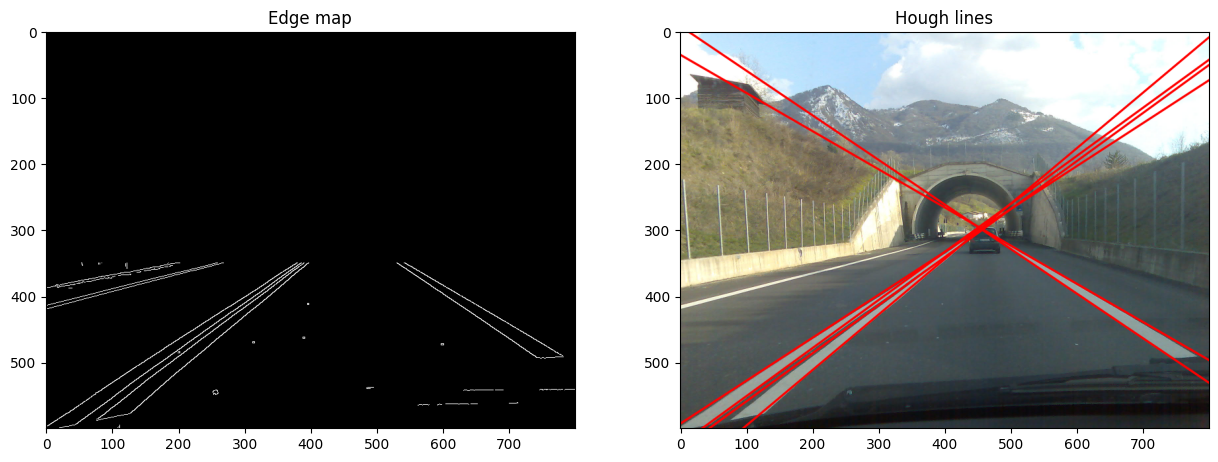

In [13]:
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [ ]:
'''Важность разрешения преобразования Хафа:
Да, разрешение преобразования Хафа очень важно для получения хорошего результата. Вот почему:

Слишком низкое разрешение может привести к пропуску или неточному обнаружению линий.
Слишком высокое разрешение может привести к чрезмерной чувствительности к шуму и обнаружению множества ложных линий.
Оптимальное разрешение позволяет точно определить положение и ориентацию линий, сохраняя баланс между чувствительностью и устойчивостью к шуму.
Разрешение по ρ (расстояние) и θ (угол) влияет на точность определения положения и наклона линий соответственно.


Важность порогового значения аккумулятора:
Да, пороговое значение аккумулятора также критически важно для хорошего результата. Причины:

Слишком низкий порог приведет к обнаружению множества ложных линий, включая шум и случайные выравнивания точек.
Слишком высокий порог может привести к пропуску реальных линий, особенно если они прерывисты или не очень четкие.
Оптимальное пороговое значение позволяет отфильтровать случайный шум, сохраняя при этом значимые линейные структуры.
Пороговое значение должно быть адаптировано к конкретным условиям изображения: освещению, контрастности, наличию теней и т.д.'''